In [1]:
pacman::p_load(data.table,ggplot2,ggalt,ggthemes,lubridate,dplyr,RColorBrewer,patchwork,colorspace)

In [2]:
wrld <- map_data("world")

gg <- ggplot()
gg <- gg + geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)
gg <- gg + coord_proj("+proj=robin +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
gg <- gg + theme_map()

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message:
“Using `size` aesthetic for lines was
deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


In [3]:
morewidthsdir_temp="../data/Darwin_Simulations/ModWidths_FixedHet_MostConservative"

morewidthsdir="../data/Darwin_Simulations/ModWidths_FixedHet_MostConservative_Large_Penalty"

temps_ModWidths_ConRange_MoreWidths=data.frame(fread(file.path(morewidthsdir_temp,
                                    "tave.ScenarioB_no_low_opt.revise.concatenated_temp_phys_tave_monthly_all_biomass.csv")))

temps_ModWidths_ConRange_MoreWidths=temps_ModWidths_ConRange_MoreWidths %>%
    dplyr::mutate(DateTime = strptime(Time, format='%Y-%b-%d %H:%M:%S'))

In [4]:
large_penalty=data.frame(fread(file.path(morewidthsdir,
                                         "ScenarioB_depths_2Oct2023_temp_tave_monthly_all_biomass.csv")))

In [5]:
large_penalty = large_penalty %>%
    dplyr::mutate(DateTime = strptime(Time, format='%Y-%b-%d %H:%M:%S'))

In [6]:
head(large_penalty)

V1 ind_T ind_Z ind_Y ind_X biomass T       Z  Y     X   Scenario Basin
1 0  0     0     0     0     0       2592000 -5 -79.5 0.5 A        BATS 
2 1  0     0     0     1     0       2592000 -5 -79.5 1.5 A        BATS 
3 2  0     0     0     2     0       2592000 -5 -79.5 2.5 A        BATS 
4 3  0     0     0     3     0       2592000 -5 -79.5 3.5 A        BATS 
5 4  0     0     0     4     0       2592000 -5 -79.5 4.5 A        BATS 
6 5  0     0     0     5     0       2592000 -5 -79.5 5.5 A        BATS 
  Time                 Tracer Longitude Latitude DateTime           
1 2000-Jan-30 07:00:00 1      0.5       -79.5    2000-01-30 07:00:00
2 2000-Jan-30 07:00:00 1      1.5       -79.5    2000-01-30 07:00:00
3 2000-Jan-30 07:00:00 1      2.5       -79.5    2000-01-30 07:00:00
4 2000-Jan-30 07:00:00 1      3.5       -79.5    2000-01-30 07:00:00
5 2000-Jan-30 07:00:00 1      4.5       -79.5    2000-01-30 07:00:00
6 2000-Jan-30 07:00:00 1      5.5       -79.5    2000-01-30 07:00:00

In [7]:
list_of_temp_opt=c(0.0,3.5,7,10.5,14,17.5,21,24.5,28,31.5)
list_of_a=rev(sort(rep(c(0.30,0.29,0.28,0.27,0.26,0.25),10)))
list_of_b=rep(0.066171077,60)
list_of_w=sort(rep(c(16,18,20,22,24,26),10))
tracer=c(1:60)
generalist_specialist_vals=data.frame("Tracer"=tracer,
                                 "w"=list_of_w,
                                 "a"=list_of_a,
                                 "b"=list_of_b,
                                 "opt"=list_of_temp_opt,
                                 "Scenario"="Generalist-Specialist")

list_of_temp_opt=c(0.0,3.5,7,10.5,14,17.5,21,24.5,28,31.5)
list_of_a=rev(sort(rep(c(0.30,0.25,0.2,0.15,0.1,0.05),10)))
list_of_b=rep(0.066171077,60)
list_of_w=sort(rep(c(16,18,20,22,24,26),10))
tracer=c(1:60)
large_penalty_vals=data.frame("Tracer"=tracer,
                                 "w"=list_of_w,
                                 "a"=list_of_a,
                                 "b"=list_of_b,
                                 "opt"=list_of_temp_opt,
                                 "Scenario"="Generalist-LargePenalty")

In [8]:
merged_scenarios=generalist_specialist_vals %>% dplyr::bind_rows(large_penalty_vals)

In [9]:
norberg <- function(a,b,width,opt,Temps){
    all_nb=c()
    for (Temp in Temps) {
        if (a*exp(b*Temp)*(1-((Temp-opt)/(width/2))^2) > 0) {
            all_nb=c(all_nb,a*exp(b*Temp)*(1-((Temp-opt)/(width/2))^2))
        } else {
            all_nb=c(all_nb,0)
        }
    }
    return(paste(all_nb,collapse=","))
}

In [10]:
temp_vect=seq(-5,35,length.out=200)
merged_w_vals=merged_scenarios %>% rowwise() %>% dplyr::mutate(norberg_vals=norberg(a,b,w,opt,temp_vect),
                                                               temps=paste(temp_vect,collapse=","))

In [11]:
combine_all_w_temp=temps_ModWidths_ConRange_MoreWidths %>%
         dplyr::filter(DateTime>as.Date("2008-12-01")) %>%
                    dplyr::select(Latitude,Longitude,Time,Tpot_tave,DateTime) %>%
                    dplyr::left_join(large_penalty %>%
                                     dplyr::select(DateTime,Tracer,biomass,Latitude,Longitude) %>%
                                     dplyr::filter(DateTime>as.Date("2008-12-01")),
                                     by=c("Latitude","Longitude","DateTime"))

merged_all_w_temp_scen=combine_all_w_temp %>%
    dplyr::left_join(large_penalty_vals, by=c("Tracer"))
merged_all_w_temp_scen["ToptDist"] =  merged_all_w_temp_scen["opt"]-merged_all_w_temp_scen["Tpot_tave"]

In [12]:
mean_biomass = merged_all_w_temp_scen %>%
    dplyr::group_by(Latitude,Longitude,DateTime) %>%
    dplyr::summarize(biomass=sum(biomass)) %>% dplyr::ungroup() %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(biomass=mean(biomass))

`summarise()` has grouped output by
'Latitude', 'Longitude'. You can
override using the `.groups` argument.
`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.


Latitude Longitude biomass
1 -79.5    0.5       0      
2 -79.5    1.5       0      
3 -79.5    2.5       0      
4 -79.5    3.5       0      
5 -79.5    4.5       0      
6 -79.5    5.5       0

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


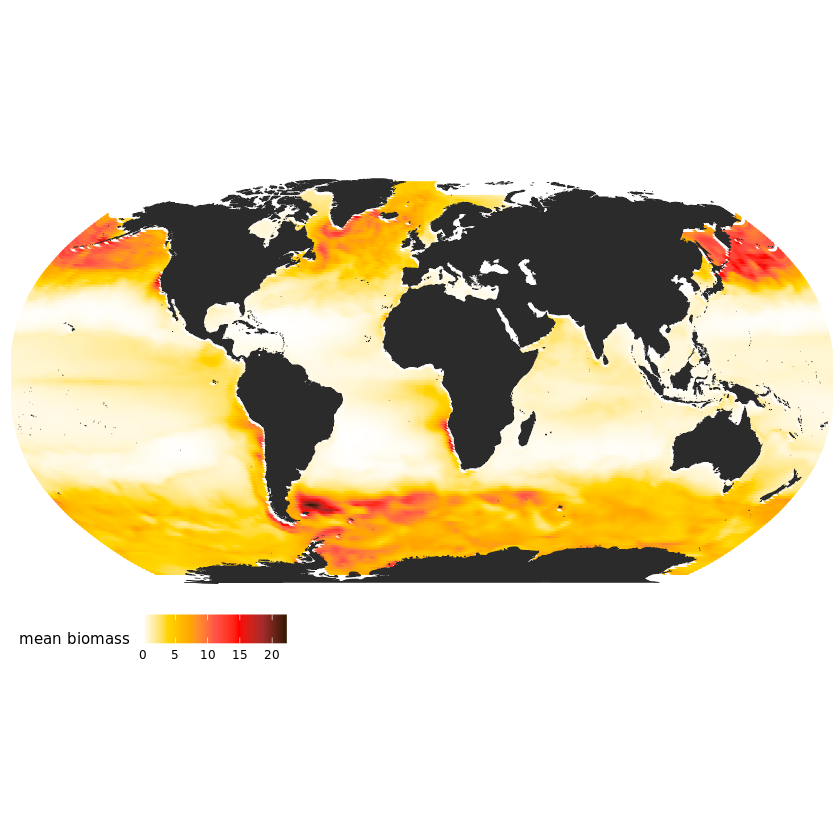

In [13]:
head(mean_biomass)

gg + geom_point(data=mean_biomass %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180),
                aes(x=Longitude, y = Latitude, color = biomass)) + 
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="mean biomass")+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)

In [14]:
mean_biomass = merged_all_w_temp_scen.groupby(["Latitude","Longitude","DateTime"]).biomass.sum().\
    reset_index().group_by(["Latitude","Longitude"]).biomass.mean()

ERROR: Error in parse(text = x, srcfile = src): <text>:1:47: unexpected '['
1: mean_biomass = merged_all_w_temp_scen.groupby([
                                                  ^


In [15]:
rm(large_penalty)

`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


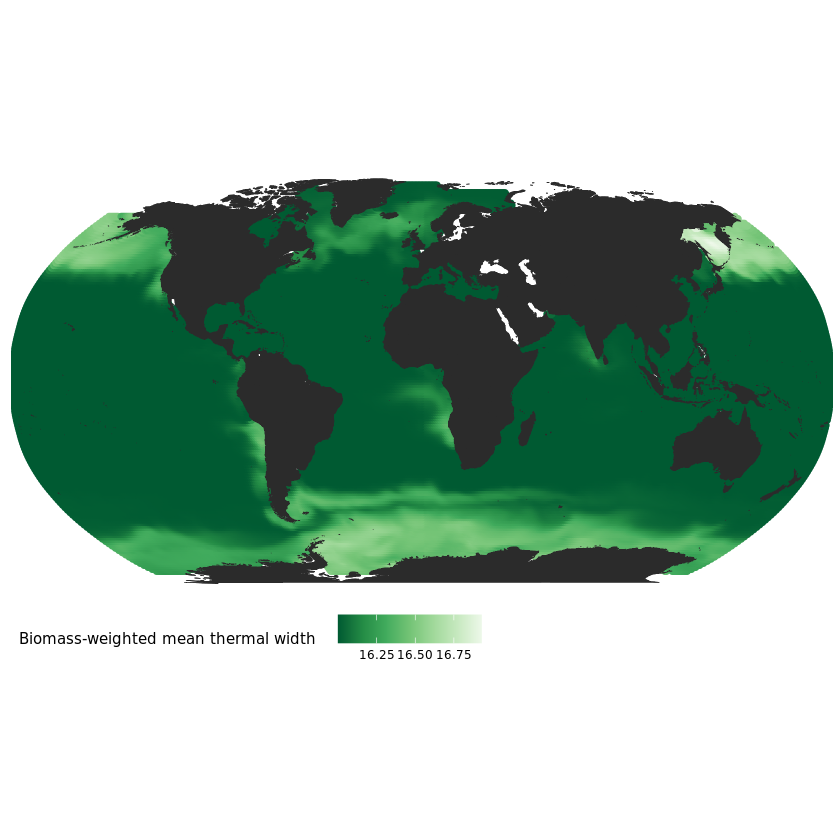

In [16]:
# filter based on time
duplicates_dropped_filt = merged_all_w_temp_scen %>% 
    dplyr::filter(DateTime>as.POSIXct("2008-12-01",format="%Y-%m-%d"))

# get total biomass of all time in last year of sim
total_biomass=duplicates_dropped_filt %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(total_biomass=sum(biomass,na.rm=TRUE))

# summarize weighted biomass in final year of simulation
duplicates_dropped_filt_summary = duplicates_dropped_filt %>% 
    dplyr::left_join(total_biomass,by=c("Latitude","Longitude")) %>%
    dplyr::mutate(WeightedWidths=(w*biomass)/total_biomass) %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(WeightedWidth=sum(WeightedWidths,na.rm=TRUE))

thermal_widths=gg + geom_point(data=duplicates_dropped_filt_summary %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    scale_color_distiller(palette="Greens",
                          na.value="black",name="Biomass-weighted mean thermal width")+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)

thermal_widths

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


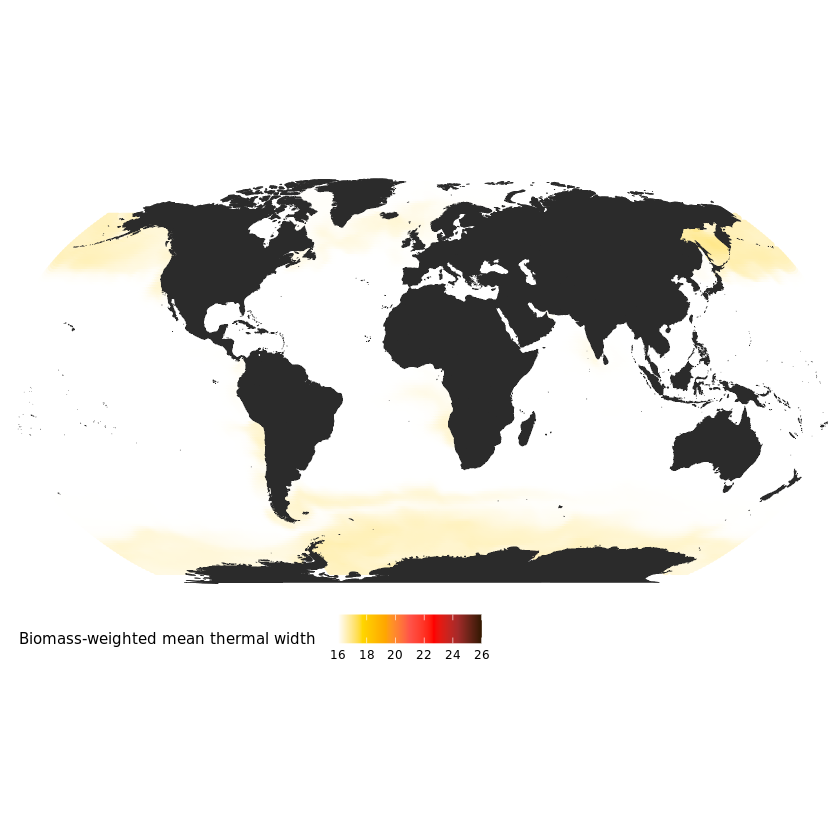

In [17]:
thermal_widths=gg + geom_point(data=duplicates_dropped_filt_summary %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    #scale_color_distiller(palette="YlGnBu",direction=1,
    #                      na.value="black",name="Biomass-weighted mean thermal width")+
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="Biomass-weighted mean thermal width",
                          limits=c(16,26))+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)
thermal_widths

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


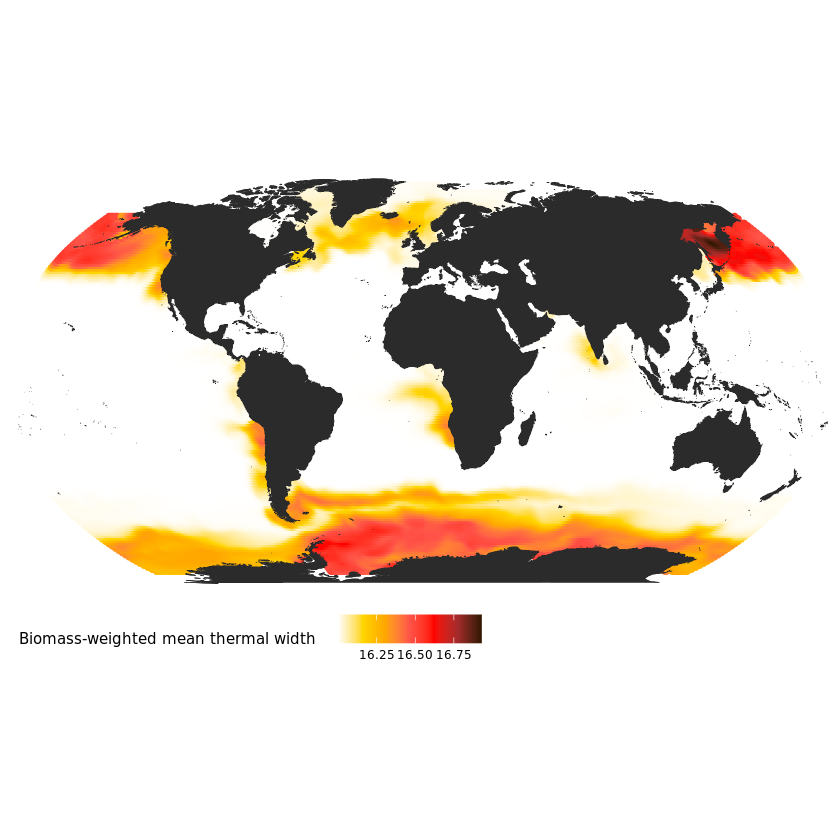

In [18]:
thermal_widths=gg + geom_point(data=duplicates_dropped_filt_summary %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    #scale_color_distiller(palette="YlGnBu",direction=1,
    #                      na.value="black",name="Biomass-weighted mean thermal width")+
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="Biomass-weighted mean thermal width")+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)
thermal_widths

In [19]:
morewidthsdir_no="/proj/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/data/Darwin_Simulations/ModWidths_FixedHet_MostConservative_No_Penalty"

no_penalty=data.frame(fread(file.path(morewidthsdir_no,
                                      "ScenarioB_depths_2Oct2023_temp_tave_monthly_all_biomass.csv")))

no_penalty = no_penalty %>%
    dplyr::mutate(DateTime = strptime(Time, format='%Y-%b-%d %H:%M:%S'))

In [20]:
list_of_temp_opt=c(0.0,3.5,7,10.5,14,17.5,21,24.5,28,31.5)
list_of_a=rev(sort(rep(c(0.30,0.30,0.30,0.30,0.30,0.30),10)))
list_of_b=rep(0.066171077,60)
list_of_w=sort(rep(c(16,18,20,22,24,26),10))
tracer=c(1:60)
no_penalty_vals=data.frame("Tracer"=tracer,
                                 "w"=list_of_w,
                                 "a"=list_of_a,
                                 "b"=list_of_b,
                                 "opt"=list_of_temp_opt,
                                 "Scenario"="Generalist-NoPenalty")

In [21]:
norberg <- function(a,b,width,opt,Temps){
    all_nb=c()
    for (Temp in Temps) {
        if (a*exp(b*Temp)*(1-((Temp-opt)/(width/2))^2) > 0) {
            all_nb=c(all_nb,a*exp(b*Temp)*(1-((Temp-opt)/(width/2))^2))
        } else {
            all_nb=c(all_nb,0)
        }
    }
    return(paste(all_nb,collapse=","))
}

merged_scenarios=generalist_specialist_vals %>% dplyr::bind_rows(large_penalty_vals) %>%
    dplyr::bind_rows(no_penalty_vals)

temp_vect=seq(-5,35,length.out=200)
merged_w_vals_no=merged_scenarios %>% rowwise() %>% dplyr::mutate(norberg_vals=norberg(a,b,w,opt,temp_vect),
                                                               temps=paste(temp_vect,collapse=","))


combine_all_w_temp_no=temps_ModWidths_ConRange_MoreWidths %>%
         dplyr::filter(DateTime>as.Date("2008-12-01")) %>%
                    dplyr::select(Latitude,Longitude,Time,Tpot_tave,DateTime) %>%
                    dplyr::left_join(no_penalty %>%
                                     dplyr::select(DateTime,Tracer,biomass,Latitude,Longitude) %>%
                                     dplyr::filter(DateTime>as.Date("2008-12-01")),
                                     by=c("Latitude","Longitude","DateTime"))

merged_all_w_temp_scen_no=combine_all_w_temp_no %>%
    dplyr::left_join(no_penalty_vals, by=c("Tracer"))
merged_all_w_temp_scen_no["ToptDist"] =  merged_all_w_temp_scen_no["opt"]-merged_all_w_temp_scen_no["Tpot_tave"]

`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


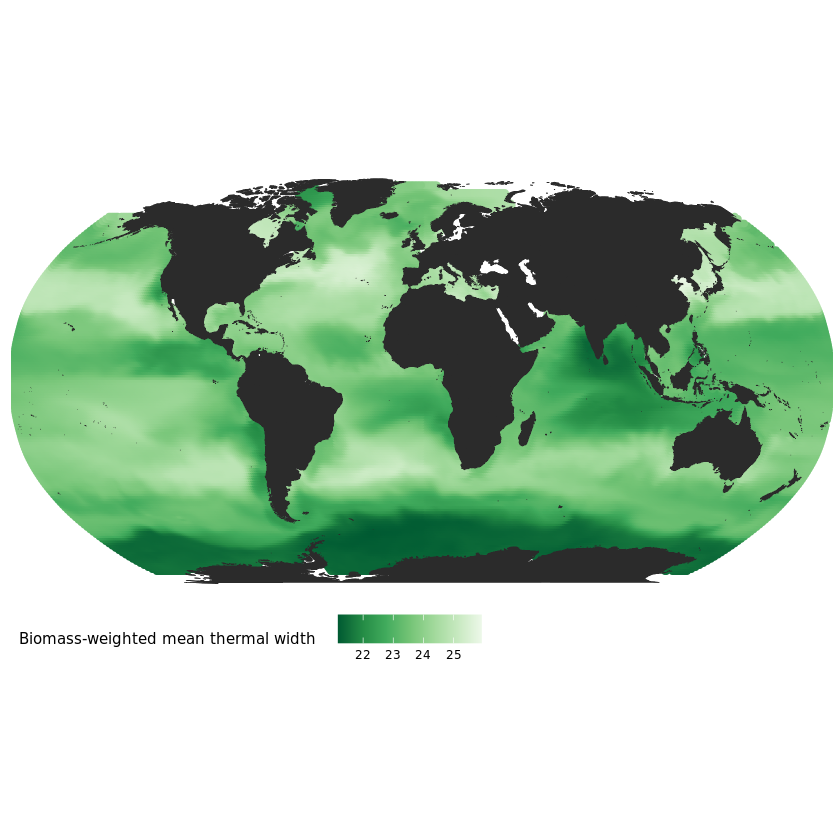

In [22]:
# filter based on time
duplicates_dropped_filt_no = merged_all_w_temp_scen_no %>% 
    dplyr::filter(DateTime>as.POSIXct("2008-12-01",format="%Y-%m-%d"))

# get total biomass of all time in last year of sim
total_biomass_no=duplicates_dropped_filt_no %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(total_biomass=sum(biomass,na.rm=TRUE))

# summarize weighted biomass in final year of simulation
duplicates_dropped_filt_summary_no = duplicates_dropped_filt_no %>% 
    dplyr::left_join(total_biomass_no,by=c("Latitude","Longitude")) %>%
    dplyr::mutate(WeightedWidths=(w*biomass)/total_biomass) %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(WeightedWidth=sum(WeightedWidths,na.rm=TRUE))

thermal_widths_no=gg + geom_point(data=duplicates_dropped_filt_summary_no %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    scale_color_distiller(palette="Greens",
                          na.value="black",name="Biomass-weighted mean thermal width")+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)

thermal_widths_no

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


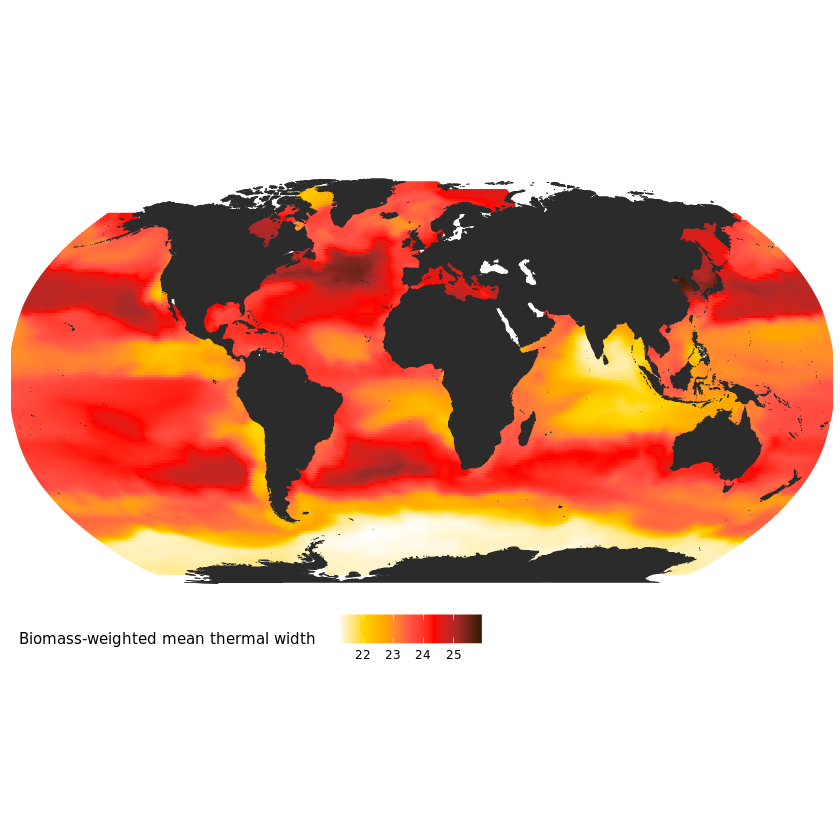

In [23]:
thermal_widths_no=gg + geom_point(data=duplicates_dropped_filt_summary_no %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    #scale_color_distiller(palette="YlGnBu",direction=1,
    #                      na.value="black",name="Biomass-weighted mean thermal width")+
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="Biomass-weighted mean thermal width")+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)
thermal_widths_no

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


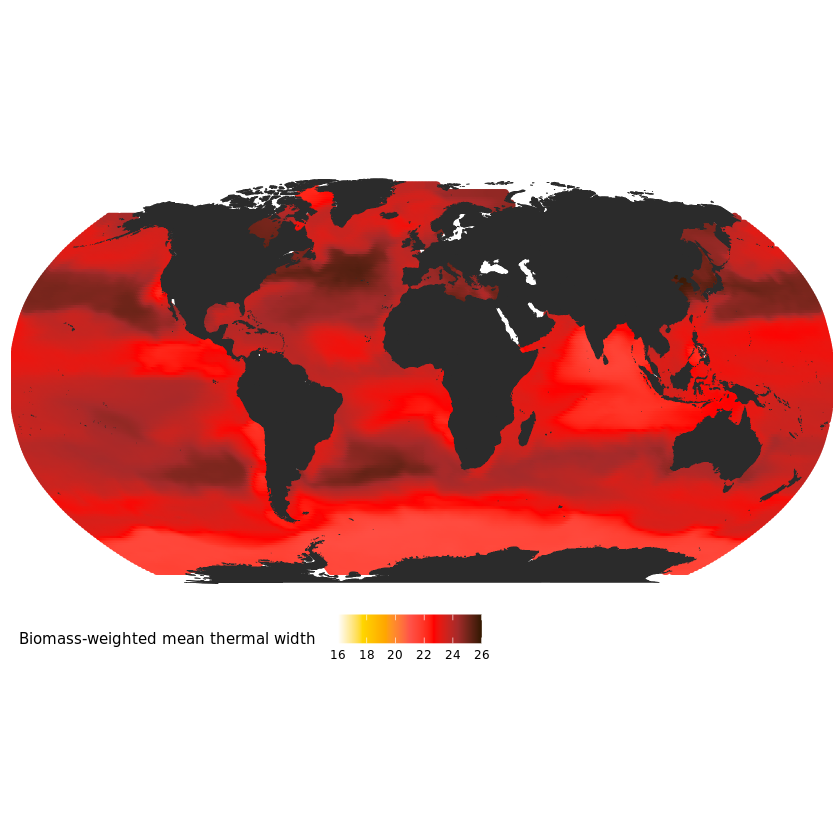

In [24]:
thermal_widths_no=gg + geom_point(data=duplicates_dropped_filt_summary_no %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    #scale_color_distiller(palette="YlGnBu",direction=1,
    #                      na.value="black",name="Biomass-weighted mean thermal width")+
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="Biomass-weighted mean thermal width",
                          limits=c(16,26))+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)
thermal_widths_no

In [25]:
rm(no_penalty)

In [26]:
mean_biomass_no = merged_all_w_temp_scen_no %>%
    dplyr::group_by(Latitude,Longitude,DateTime) %>%
    dplyr::summarize(biomass=sum(biomass)) %>% dplyr::ungroup() %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(biomass=mean(biomass))

`summarise()` has grouped output by
'Latitude', 'Longitude'. You can
override using the `.groups` argument.
`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.


Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


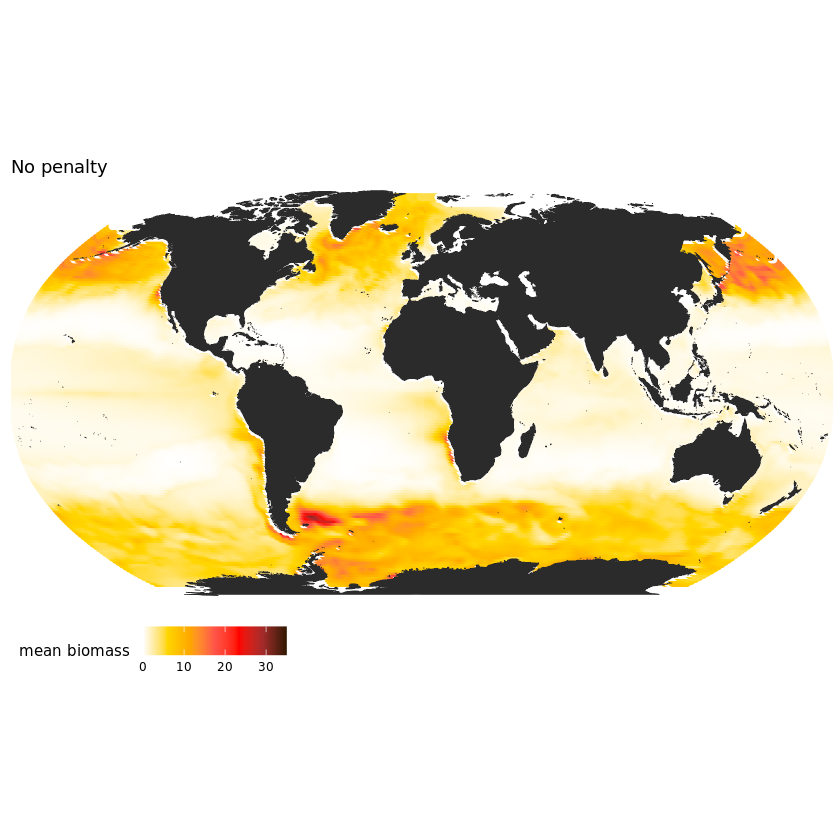

In [27]:
gg + geom_point(data=mean_biomass_no %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180),
                aes(x=Longitude, y = Latitude, color = biomass)) + 
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="mean biomass",limits=c(0,35))+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)+
    ggtitle("No penalty")

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


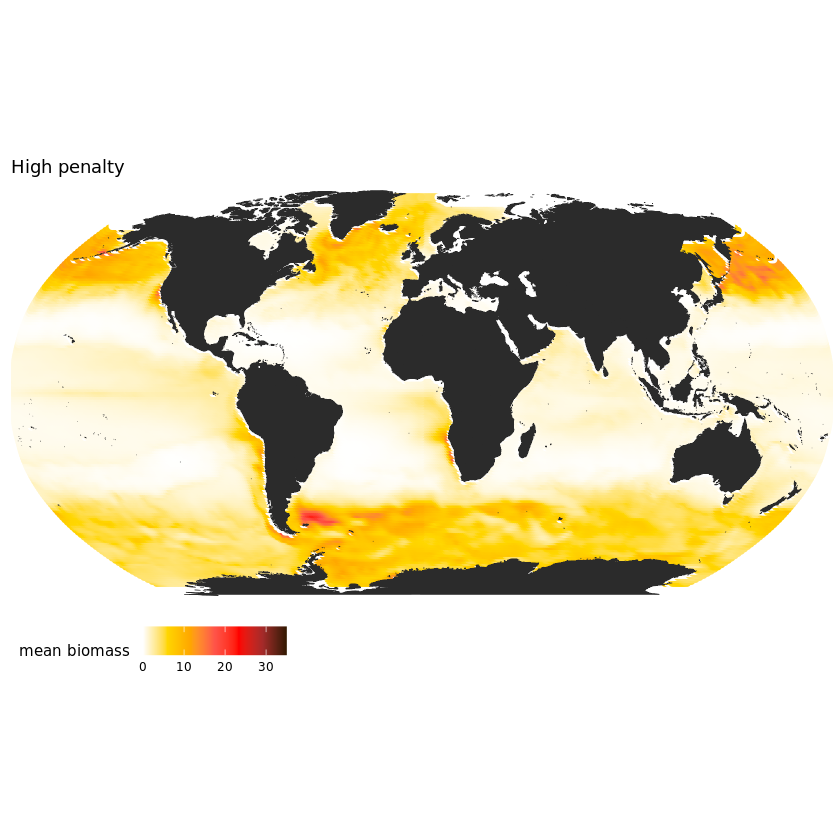

In [28]:
gg + geom_point(data=mean_biomass %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180),
                aes(x=Longitude, y = Latitude, color = biomass)) + 
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="mean biomass",limits=c(0,35))+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA) + 
    ggtitle("High penalty")

## Intermediate penalty.

In [29]:
morewidthsdir_mid="/proj/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/data/Darwin_Simulations/ModWidths_FixedHet_MostConservative"

mid_penalty=data.frame(fread(file.path(morewidthsdir_mid,
                                      "ScenarioB_depths_2Oct2023_temp_tave_monthly_all_biomass.csv")))

mid_penalty = mid_penalty %>%
    dplyr::mutate(DateTime = strptime(Time, format='%Y-%b-%d %H:%M:%S'))

In [30]:
list_of_temp_opt=c(0.0,3.5,7,10.5,14,17.5,21,24.5,28,31.5)
list_of_a=rev(sort(rep(c(0.30,0.29,0.28,0.27,0.26,0.25),10)))
list_of_b=rep(0.066171077,60)
list_of_w=sort(rep(c(16,18,20,22,24,26),10))
tracer=c(1:60)
mid_penalty_vals=data.frame("Tracer"=tracer,
                                 "w"=list_of_w,
                                 "a"=list_of_a,
                                 "b"=list_of_b,
                                 "opt"=list_of_temp_opt,
                                 "Scenario"="Generalist-MidPenalty")

In [31]:
norberg <- function(a,b,width,opt,Temps){
    all_nb=c()
    for (Temp in Temps) {
        if (a*exp(b*Temp)*(1-((Temp-opt)/(width/2))^2) > 0) {
            all_nb=c(all_nb,a*exp(b*Temp)*(1-((Temp-opt)/(width/2))^2))
        } else {
            all_nb=c(all_nb,0)
        }
    }
    return(paste(all_nb,collapse=","))
}

merged_scenarios=generalist_specialist_vals %>% dplyr::bind_rows(large_penalty_vals) %>%
    dplyr::bind_rows(no_penalty_vals) %>% dplyr::bind_rows(mid_penalty_vals)

temp_vect=seq(-5,35,length.out=200)
merged_w_vals_mid=merged_scenarios %>% rowwise() %>% dplyr::mutate(norberg_vals=norberg(a,b,w,opt,temp_vect),
                                                               temps=paste(temp_vect,collapse=","))


combine_all_w_temp_mid=temps_ModWidths_ConRange_MoreWidths %>%
         dplyr::filter(DateTime>as.Date("2008-12-01")) %>%
                    dplyr::select(Latitude,Longitude,Time,Tpot_tave,DateTime) %>%
                    dplyr::left_join(mid_penalty %>%
                                     dplyr::select(DateTime,Tracer,biomass,Latitude,Longitude) %>%
                                     dplyr::filter(DateTime>as.Date("2008-12-01")),
                                     by=c("Latitude","Longitude","DateTime"))

merged_all_w_temp_scen_mid=combine_all_w_temp_mid %>%
    dplyr::left_join(mid_penalty_vals, by=c("Tracer"))
merged_all_w_temp_scen_mid["ToptDist"] =  merged_all_w_temp_scen_mid["opt"]-merged_all_w_temp_scen_mid["Tpot_tave"]

In [32]:
rm(mid_penalty)

`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


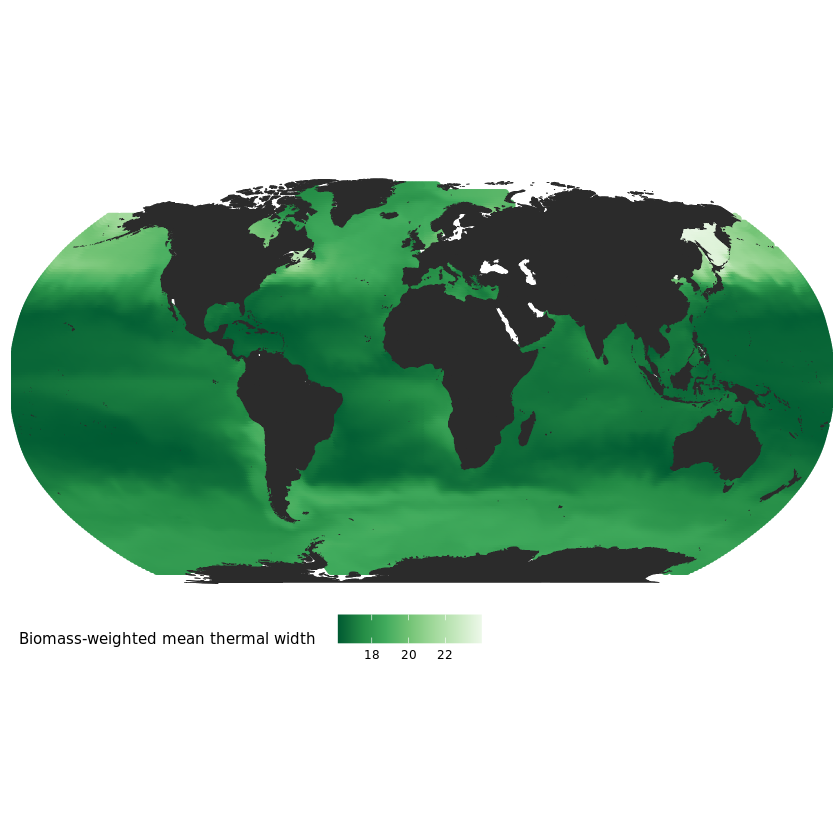

In [33]:
# filter based on time
duplicates_dropped_filt_mid = merged_all_w_temp_scen_mid %>% 
    dplyr::filter(DateTime>as.POSIXct("2008-12-01",format="%Y-%m-%d"))

# get total biomass of all time in last year of sim
total_biomass_mid=duplicates_dropped_filt_mid %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(total_biomass=sum(biomass,na.rm=TRUE))

# summarize weighted biomass in final year of simulation
duplicates_dropped_filt_summary_mid = duplicates_dropped_filt_mid %>% 
    dplyr::left_join(total_biomass_mid,by=c("Latitude","Longitude")) %>%
    dplyr::mutate(WeightedWidths=(w*biomass)/total_biomass) %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(WeightedWidth=sum(WeightedWidths,na.rm=TRUE))

thermal_widths_mid=gg + geom_point(data=duplicates_dropped_filt_summary_mid %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    scale_color_distiller(palette="Greens",
                          na.value="black",name="Biomass-weighted mean thermal width")+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)

thermal_widths_mid

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


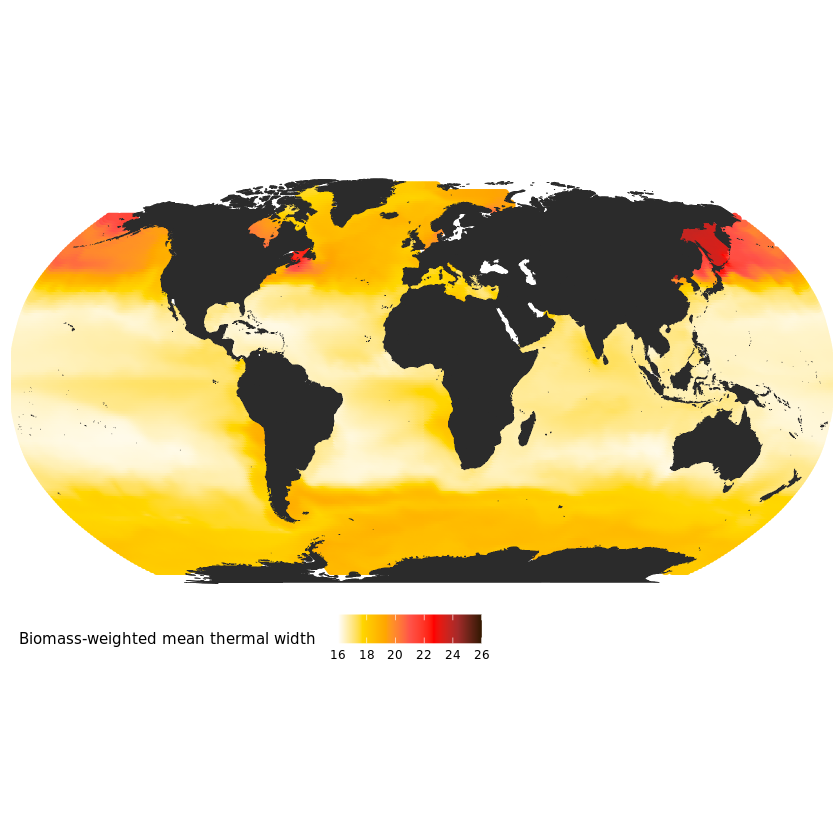

In [34]:
thermal_widths_mid=gg + geom_point(data=duplicates_dropped_filt_summary_mid %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    #scale_color_distiller(palette="YlGnBu",direction=1,
    #                      na.value="black",name="Biomass-weighted mean thermal width")+
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="Biomass-weighted mean thermal width",
                          limits=c(16,26))+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA)
thermal_widths_mid

In [35]:
write.csv(duplicates_dropped_filt_summary,"duplicates_dropped_filt_summary_large.csv")
write.csv(duplicates_dropped_filt_summary_mid,"duplicates_dropped_filt_summary_mid.csv")
write.csv(duplicates_dropped_filt_summary_no,"duplicates_dropped_filt_summary_no.csv")

In [36]:
merged_all_dups = duplicates_dropped_filt_summary %>% dplyr::mutate(Scenario="Generalist-LargePenalty") %>% 
    dplyr::bind_rows(duplicates_dropped_filt_summary_mid %>%
                     dplyr::mutate(Scenario="Generalist-MidPenalty"))%>% 
    dplyr::bind_rows(duplicates_dropped_filt_summary_no %>%
                     dplyr::mutate(Scenario="Generalist-NoPenalty"))

Warning message:
“Duplicated aesthetics after name
standardisation: fill”
Warning message in geom_map(data = wrld, map = wrld, aes(x = long, y = lat, map_id = region), :
“Ignoring unknown aesthetics: x and y”


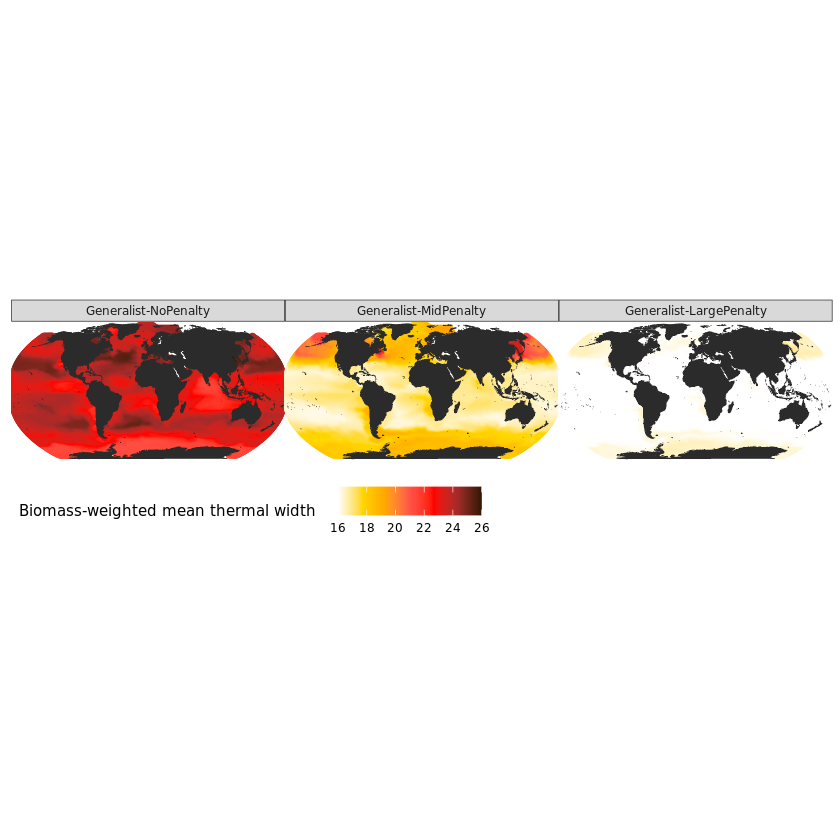

In [37]:
thermal_widths_merged=gg + geom_point(data=merged_all_dups %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0),
                aes(x=Longitude, y = Latitude, color = WeightedWidth)) + 
    scale_color_gradientn(colors=c("white","gold","orange","#ff5349","red","brown","#331800"),
                          na.value="black",name="Biomass-weighted mean thermal width",
                          limits=c(16,26))+
    theme(legend.position = "bottom")+ geom_map(data=wrld, map=wrld,
                    aes(x=long, y=lat, map_id=region),
                    color="#2b2b2b", fill="#2b2b2b",size=0.15, fill=NA) + 
    facet_wrap(~factor(Scenario,levels=c("Generalist-NoPenalty","Generalist-MidPenalty",
                                        "Generalist-LargePenalty")))
thermal_widths_merged

In [38]:
merged_scenarios = large_penalty_vals %>%
    dplyr::bind_rows(no_penalty_vals) %>% dplyr::bind_rows(mid_penalty_vals)
merged_scenarios

Tracer w  a    b          opt  Scenario               
1    1     16 0.30 0.06617108  0.0 Generalist-LargePenalty
2    2     16 0.30 0.06617108  3.5 Generalist-LargePenalty
3    3     16 0.30 0.06617108  7.0 Generalist-LargePenalty
4    4     16 0.30 0.06617108 10.5 Generalist-LargePenalty
5    5     16 0.30 0.06617108 14.0 Generalist-LargePenalty
6    6     16 0.30 0.06617108 17.5 Generalist-LargePenalty
7    7     16 0.30 0.06617108 21.0 Generalist-LargePenalty
8    8     16 0.30 0.06617108 24.5 Generalist-LargePenalty
9    9     16 0.30 0.06617108 28.0 Generalist-LargePenalty
10  10     16 0.30 0.06617108 31.5 Generalist-LargePenalty
11  11     18 0.25 0.06617108  0.0 Generalist-LargePenalty
12  12     18 0.25 0.06617108  3.5 Generalist-LargePenalty
13  13     18 0.25 0.06617108  7.0 Generalist-LargePenalty
14  14     18 0.25 0.06617108 10.5 Generalist-LargePenalty
15  15     18 0.25 0.06617108 14.0 Generalist-LargePenalty
16  16     18 0.25 0.06617108 17.5 Generalist-LargePenalty
17  17     18 0.25 0.06617108 21.0 Generalist-LargePenalty
18  18     18 0.25 0.06617108 24.5 Generalist-LargePenalty
19  19     18 0.25 0.06617108 28.0 Generalist-LargePenalty
20  20     18 0.25 0.06617108 31.5 Generalist-LargePenalty
21  21     20 0.20 0.06617108  0.0 Generalist-LargePenalty
22  22     20 0.20 0.06617108  3.5 Generalist-LargePenalty
23  23     20 0.20 0.06617108  7.0 Generalist-LargePenalty
24  24     20 0.20 0.06617108 10.5 Generalist-LargePenalty
25  25     20 0.20 0.06617108 14.0 Generalist-LargePenalty
26  26     20 0.20 0.06617108 17.5 Generalist-LargePenalty
27  27     20 0.20 0.06617108 21.0 Generalist-LargePenalty
28  28     20 0.20 0.06617108 24.5 Generalist-LargePenalty
29  29     20 0.20 0.06617108 28.0 Generalist-LargePenalty
30  30     20 0.20 0.06617108 31.5 Generalist-LargePenalty
⋮   ⋮      ⋮  ⋮    ⋮          ⋮    ⋮                      
151 31     22 0.27 0.06617108  0.0 Generalist-MidPenalty  
152 32     22 0.27 0.06617108  3.5 Generalist-MidPenalty  
153 33     22 0.27 0.06617108  7.0 Generalist-MidPenalty  
154 34     22 0.27 0.06617108 10.5 Generalist-MidPenalty  
155 35     22 0.27 0.06617108 14.0 Generalist-MidPenalty  
156 36     22 0.27 0.06617108 17.5 Generalist-MidPenalty  
157 37     22 0.27 0.06617108 21.0 Generalist-MidPenalty  
158 38     22 0.27 0.06617108 24.5 Generalist-MidPenalty  
159 39     22 0.27 0.06617108 28.0 Generalist-MidPenalty  
160 40     22 0.27 0.06617108 31.5 Generalist-MidPenalty  
161 41     24 0.26 0.06617108  0.0 Generalist-MidPenalty  
162 42     24 0.26 0.06617108  3.5 Generalist-MidPenalty  
163 43     24 0.26 0.06617108  7.0 Generalist-MidPenalty  
164 44     24 0.26 0.06617108 10.5 Generalist-MidPenalty  
165 45     24 0.26 0.06617108 14.0 Generalist-MidPenalty  
166 46     24 0.26 0.06617108 17.5 Generalist-MidPenalty  
167 47     24 0.26 0.06617108 21.0 Generalist-MidPenalty  
168 48     24 0.26 0.06617108 24.5 Generalist-MidPenalty  
169 49     24 0.26 0.06617108 28.0 Generalist-MidPenalty  
170 50     24 0.26 0.06617108 31.5 Generalist-MidPenalty  
171 51     26 0.25 0.06617108  0.0 Generalist-MidPenalty  
172 52     26 0.25 0.06617108  3.5 Generalist-MidPenalty  
173 53     26 0.25 0.06617108  7.0 Generalist-MidPenalty  
174 54     26 0.25 0.06617108 10.5 Generalist-MidPenalty  
175 55     26 0.25 0.06617108 14.0 Generalist-MidPenalty  
176 56     26 0.25 0.06617108 17.5 Generalist-MidPenalty  
177 57     26 0.25 0.06617108 21.0 Generalist-MidPenalty  
178 58     26 0.25 0.06617108 24.5 Generalist-MidPenalty  
179 59     26 0.25 0.06617108 28.0 Generalist-MidPenalty  
180 60     26 0.25 0.06617108 31.5 Generalist-MidPenalty

In [39]:
temp_vect=seq(-5,35,length.out=200)
merged_w_vals=merged_scenarios %>% rowwise() %>% dplyr::mutate(norberg_vals=norberg(a,b,w,opt,temp_vect),
                                                               temps=paste(temp_vect,collapse=","))

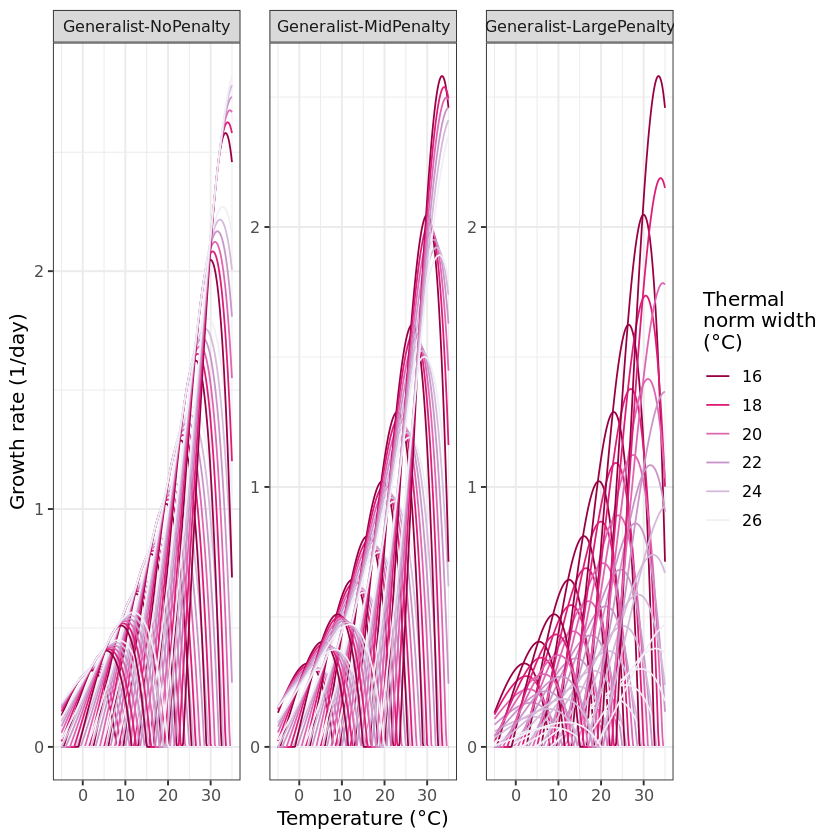

In [40]:
scenarios_plot = ggplot(merged_w_vals %>% tidyr::separate_rows(norberg_vals,temps,sep=",")) + 
    geom_line(aes(x = as.numeric(temps),
                  y=as.numeric(norberg_vals),group=paste0(opt,w),color=factor(w))) + 
    facet_wrap(~factor(Scenario,levels=c("Generalist-NoPenalty","Generalist-MidPenalty",
                                        "Generalist-LargePenalty")),nrow=1,
              scales="free_y") + theme_bw(base_size=12) + 
    ylab("Growth rate (1/day)") + xlab("Temperature (°C)") +
    scale_color_brewer(palette="PuRd",name="Thermal\nnorm width\n(°C)", direction=-1)
scenarios_plot

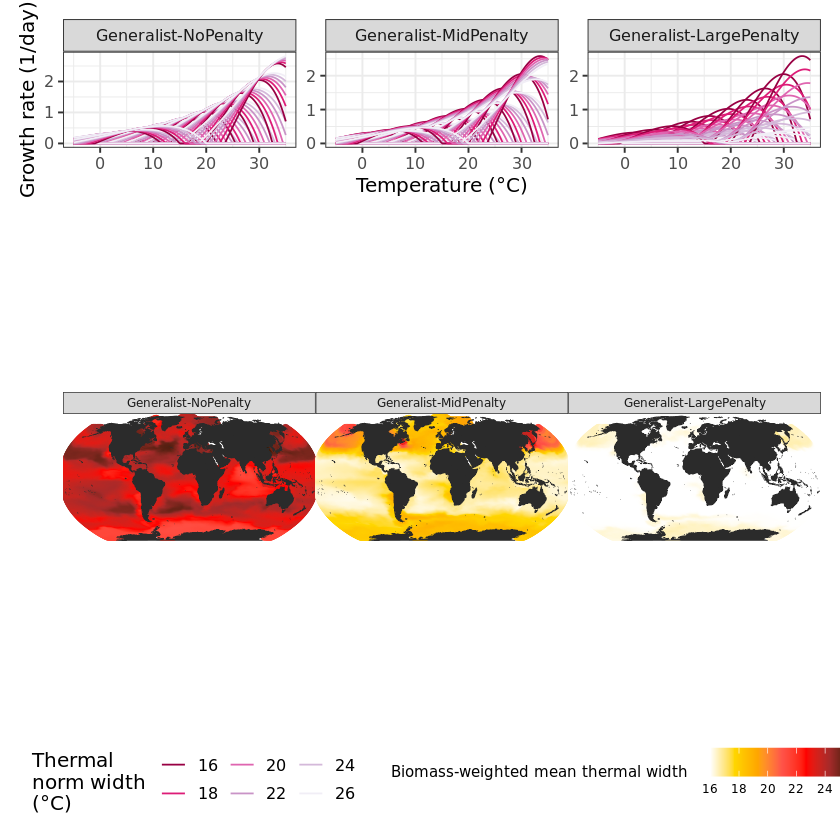

In [41]:
scenarios_plot/thermal_widths_merged + plot_layout(guides = "collect", heights = c(1, 5)) & 
    theme(legend.position = 'bottom')
ggsave("scenarios_combo.pdf",width=10,height=10,units="in")

In [42]:
mean_std_temp = merged_all_w_temp_scen %>%
    dplyr::group_by(Latitude,Longitude) %>%
    dplyr::summarize(TemperatureMean=mean(Tpot_tave,na.rm=TRUE),
                     Temperature_SD=sd(Tpot_tave,na.rm=TRUE),
                     Temperature_Range=max(Tpot_tave,na.rm=TRUE)-min(Tpot_tave,na.rm=TRUE)) %>%
    dplyr::left_join(duplicates_dropped_filt_summary %>% 
                dplyr::mutate(Longitude=(Longitude + 180) %% 360 - 180) %>% 
                dplyr::filter(!is.na(WeightedWidth)&WeightedWidth!=0) %>%
                #dplyr::filter((Latitude>35)&(Longitude>-29)&(Longitude<20)&(Latitude<70)) %>%
                dplyr::select(Latitude,Longitude,WeightedWidth))

`summarise()` has grouped output by
'Latitude'. You can override using the
`.groups` argument.
Joining with `by = join_by(Latitude,
Longitude)`


In [48]:
mid_std_temp = mean_std_temp %>% dplyr::select(-WeightedWidth) %>%
    dplyr::left_join(duplicates_dropped_filt_summary_mid)

no_std_temp = mean_std_temp %>% dplyr::select(-WeightedWidth) %>%
    dplyr::left_join(duplicates_dropped_filt_summary_no)

large_std_temp = mean_std_temp %>% dplyr::select(-WeightedWidth) %>%
    dplyr::left_join(duplicates_dropped_filt_summary)

Joining with `by = join_by(Latitude,
Longitude)`
Joining with `by = join_by(Latitude,
Longitude)`
Joining with `by = join_by(Latitude,
Longitude)`


In [69]:
stdev_temp = ggplot(mid_std_temp %>% dplyr::mutate(Scenario="MidPenalty") %>%
       dplyr::bind_rows(no_std_temp %>% dplyr::mutate(Scenario="NoPenalty"))%>%
       dplyr::bind_rows(large_std_temp %>% dplyr::mutate(Scenario="LargePenalty")) %>%
       dplyr::filter(WeightedWidth>0)) + 
    geom_point(aes(x = Temperature_SD, y = WeightedWidth,color=Latitude)) +
    scale_color_distiller(type = "div", limit = c(-90,90)) + 
    facet_wrap(~factor(Scenario,levels=c("NoPenalty","MidPenalty","LargePenalty")),
               nrow=1,scales="free_y") + xlab("Standard deviation of temperature") + 
    ylab("Weighted mean\nthermal niche width") + theme_bw(base_size=12)

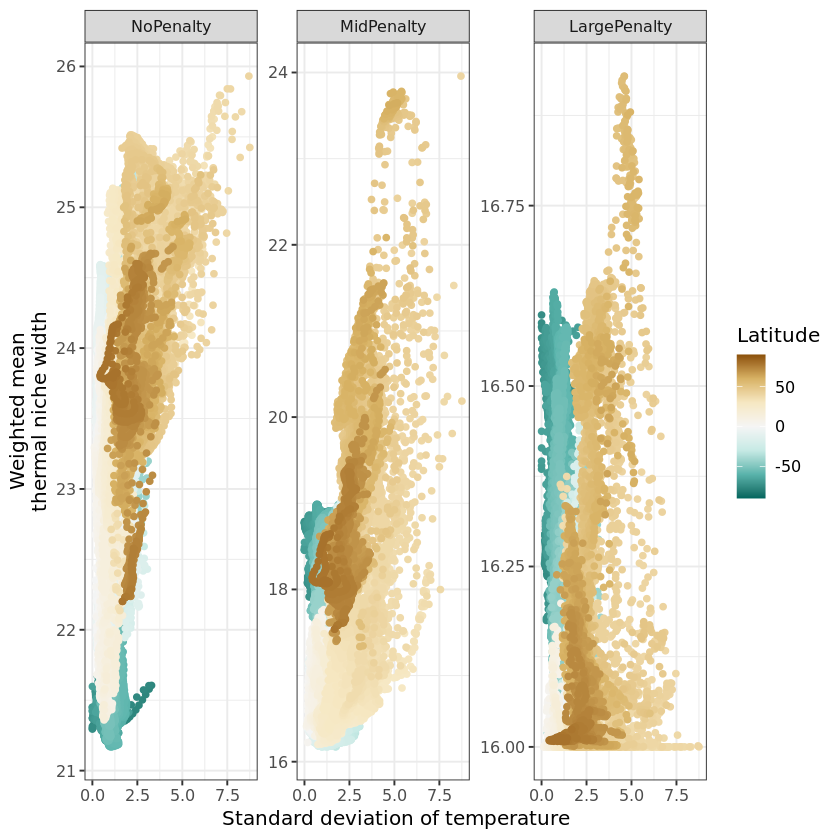

In [70]:
stdev_temp

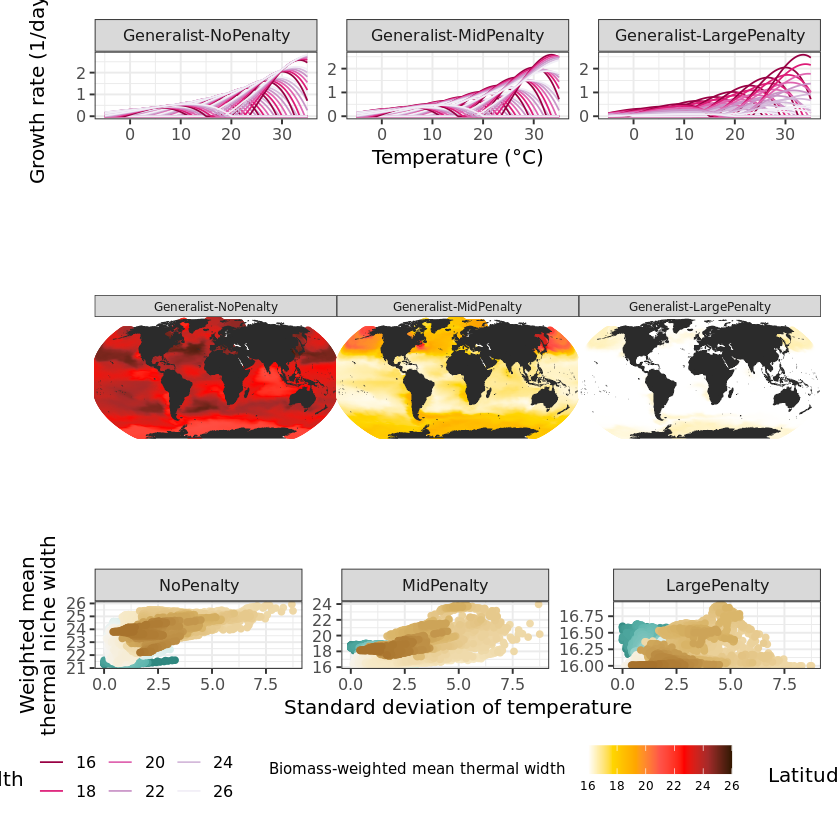

In [71]:
scenarios_plot/thermal_widths_merged/stdev_temp + plot_layout(guides = "collect", heights = c(1, 5,1)) & 
    theme(legend.position = 'bottom')

ggsave("scenarios_combo_w_temp.pdf",width=10,height=14,units="in")